In [38]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
df = pd.read_csv(
    '../../data/processed/reddit_clean_final.csv',
    keep_default_na=False,
    na_filter=False
)
df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [40]:
# Step 1: Vectorize the comments using Bag of Words (CountVectorizer)
vectorizer = CountVectorizer(max_features=3000)  # Bag of Words model with a limit of 3000 features

In [41]:
X = vectorizer.fit_transform(df['clean_comment']).toarray()
y = df['category']  # Target variable

In [42]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [43]:
X.shape

(36607, 3000)

In [44]:
y

0        1
1        1
2       -1
3        0
4        1
        ..
36602    0
36603    1
36604    0
36605    1
36606    0
Name: category, Length: 36607, dtype: int64

In [45]:
y.shape

(36607,)

In [46]:
# since will track our baseline model will set the tracking uro
# Step 2: Set up the MLflow tracking server
mlflow.set_tracking_uri("http://ec2-54-167-86-97.compute-1.amazonaws.com:5000/")

In [47]:
# Set or create an experiment
mlflow.set_experiment("RF Baseline v2")

<Experiment: artifact_location='s3://sau-s3-mlflow-bucket/854406648198928040', creation_time=1763264856300, experiment_id='854406648198928040', last_update_time=1763264856300, lifecycle_stage='active', name='RF Baseline v2', tags={}>

d:\SAURABH\spring 2024\MLOps Project\CreatorInsight AI Platform\.venv\lib\site-packages\boto3\compat.py:84: PythonDeprecationWarning: Boto3 will no longer support Python 3.9 starting April 29, 2026. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.10 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)
2025/11/15 22:59:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/15 23:00:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_Baseline_TrainTestSplit at: http://ec2-54-167-86-97.compute-1.amazonaws.com:5000/#/experiments/854406648198928040/runs/12d6fc2be5684cc18c0b5be83512b934
🧪 View experiment at: http://ec2-54-167-86-97.compute-1.amazonaws.com:5000/#/experiments/854406648198928040
Accuracy: 0.6475006828735318


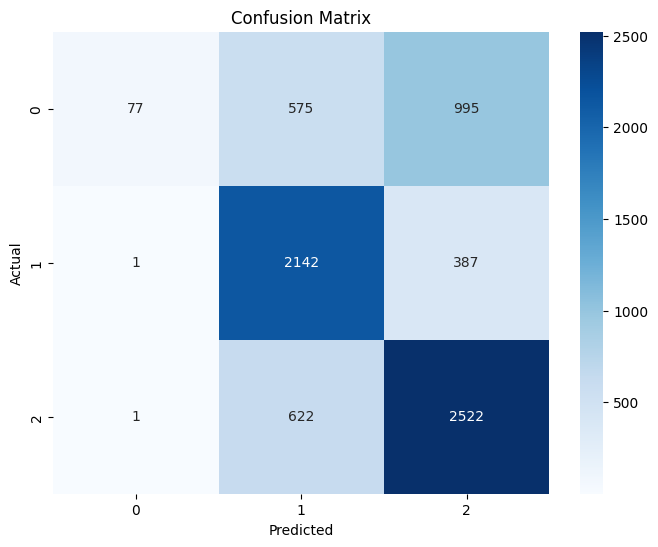

In [48]:
# Step 1: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Define and train a Random Forest baseline model using a simple train-test split
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest_Baseline_TrainTestSplit")
    mlflow.set_tag("experiment_type", "baseline")
    mlflow.set_tag("model_type", "RandomForestClassifier")

    # Add a description
    mlflow.set_tag("description", "Baseline RandomForest model for sentiment analysis using Bag of Words (BoW) with a simple train-test split")

    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("vectorizer_max_features", vectorizer.max_features)

    # Log Random Forest parameters
    n_estimators = 200
    max_depth = 15

    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)

    # Initialize and train the model
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    for label, metrics in classification_rep.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)

    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    conf_matrix_path = "../../images/evaluation/confusion_matrix.png"
    plt.savefig(conf_matrix_path)
    mlflow.log_artifact(conf_matrix_path)


    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")

    # Optionally log the dataset itself (if it's small enough)
    mlflow.log_artifact("../../data/processed/reddit_clean_final.csv")

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.97      0.05      0.09      1647
           0       0.64      0.85      0.73      2530
           1       0.65      0.80      0.72      3145

    accuracy                           0.65      7322
   macro avg       0.75      0.57      0.51      7322
weighted avg       0.72      0.65      0.58      7322

